In [1]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from utils.elpv_reader import load_dataset
import warnings
warnings.filterwarnings('ignore', category=metrics._classification.UndefinedMetricWarning)

### Step1:  Load the dataset

In [2]:
# Respectively: image, reflection probability, type. Our classifier needs to classify based on reflection probability
images, proba, types = load_dataset()
print(f"The size of the data set is: {images.shape[0]}")
print(f"The size of the image is: {images.shape[1]} * {images.shape[2]}")
print(proba)
print(types)

The size of the data set is: 2624
The size of the image is: 300 * 300
[1. 1. 1. ... 0. 0. 0.]
['mono' 'mono' 'mono' ... 'poly' 'poly' 'poly']


### Step2: Convert each image to the pixel histogram

(2624, 256)


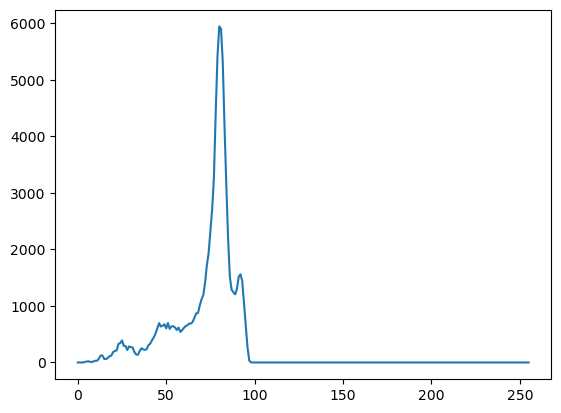

In [3]:
image_his = []

for image in images:
    hist = cv2.calcHist([image], [0], None, [256], [0.0, 255.0])
    image_his.append(hist.flatten())
    
image_his = np.array(image_his)
print(image_his.shape)
plt.plot(image_his[0])
plt.show()

### Step3: Classify images into "mono" and "poly" based on "types"

In [4]:
mono_images = []
mono_proba = []
mono_his = []
poly_images = []
poly_proba = []
poly_his = []

for i in range(len(images)):
    if types[i] == "mono":
        mono_images.append(images[i])
        mono_proba.append(proba[i])
        mono_his.append(image_his[i])
        
    elif types[i] == "poly":
        poly_images.append(images[i])
        poly_proba.append((proba[i]))
        poly_his.append(image_his[i])

# Convert lists to NumPy arrays
mono_his = np.array(mono_his)
mono_proba = np.array(mono_proba)
poly_his = np.array(poly_his)
poly_proba = np.array(poly_proba)

### Step3: Split the dataset into train set and test set

In [5]:
# split the all dataset into train set and test set
all_x_train, all_x_test, all_y_train, all_y_test = train_test_split(image_his, proba, test_size=0.25, stratify=proba, random_state=42)
# split the mono dataset into train set and test set
mono_x_train, mono_x_test, mono_y_train, mono_y_test = train_test_split(mono_his, mono_proba, test_size=0.25, stratify=mono_proba, random_state=42)
# split the poly dataset into train set and test set
poly_x_train, poly_x_test, poly_y_train, poly_y_test = train_test_split(poly_his, poly_proba, test_size=0.25, stratify=poly_proba, random_state=42)

# normalization
scaler = MinMaxScaler()
all_x_train = scaler.fit_transform(all_x_train)
all_x_test = scaler.fit_transform(all_x_test)
mono_x_train = scaler.fit_transform(mono_x_train)
mono_x_test = scaler.fit_transform(mono_x_test)
poly_x_train = scaler.fit_transform(poly_x_train)
poly_x_test = scaler.fit_transform(poly_x_test)

### Step4: Use the PCA and SVM classifier to process all dataset

In [ ]:
pipeline = Pipeline([
    ('pca', PCA()),
    ('svm', SVC())
])

param_grid = [{
    'pca__n_components': range(1, image_his.shape[1] + 1),
    'svm__C': [0.1, 1, 10, 20, 50, 100],
    'svm__kernel': ['linear']
},
{
    'pca__n_components': range(1, image_his.shape[1] + 1),
    'svm__C': [0.1, 1, 10, 20],
    'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'svm__kernel': ['rbf']
}]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=100)
grid_search.fit(all_x_train, all_y_train.astype("str"))

### Step5: Use the PCA and SVM classifier to process mono dataset

mono_grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=100)
mono_grid_search.fit(mono_x_train, mono_y_train.astype("str"))

In [7]:
### Step6: Use the PCA and SVM classifier to process poly dataset

poly_grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=100)
poly_grid_search.fit(poly_x_train, poly_y_train.astype("str"))

In [8]:
### Step7: Report the performance of the classifier

# Test

In [9]:
from sklearn.metrics import confusion_matrix
import pandas as pd

### 1. Calculate the confusion matrix for all test images

In [38]:
# Calculate the confusion matrix for all test images
predict_labels = grid_search.predict(all_x_test)
confusion_all = confusion_matrix(all_y_test.astype("str"), predict_labels)
# print(confusion_all)
confusion_all = np.array(confusion_all)

# Class label
class_labels = ["0.0", "0.3333", "0.6666", "1.0"]

# Print confusion matrix
print("Confusion Matrix (All Test Images):")
print("\t" + "\t".join(class_labels))
for i in range(len(class_labels)):
    print(class_labels[i] + "\t", end="")
    for j in range(len(class_labels)):
        print(confusion_all[i][j], end="\t")
    print()

# Calculate accuracy, recall and F1 scores
for i in range(len(class_labels)):
    tp = confusion_all[i][i]
    fp = sum(confusion_all[j][i] for j in range(len(class_labels)) if j != i)
    fn = sum(confusion_all[i][j] for j in range(len(class_labels)) if j != i)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    print(f"\nClass {class_labels[i]}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

# Calculate and output the Accuracy for each class
for i in range(len(class_labels)):
    tp = confusion_all[i][i]
    tn = sum(confusion_all[j][k] for j in range(len(class_labels)) for k in range(len(class_labels)) if j != i and k != i)
    fp = sum(confusion_all[j][i] for j in range(len(class_labels)) if j != i)
    fn = sum(confusion_all[i][j] for j in range(len(class_labels)) if j != i)
    
    accuracy_class_i = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"\nClass {class_labels[i]}:")
    print(f"Accuracy: {accuracy_class_i:.2%}")


Confusion Matrix (All Test Images):
	0.0	0.3333	0.6666	1.0
0.0	349	3	1	24	
0.3333	67	2	0	5	
0.6666	24	0	0	2	
1.0	93	0	1	85	

Class 0.0:
Precision: 0.65
Recall: 0.93
F1 Score: 0.77

Class 0.3333:
Precision: 0.40
Recall: 0.03
F1 Score: 0.05

Class 0.6666:
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class 1.0:
Precision: 0.73
Recall: 0.47
F1 Score: 0.58

Class 0.0:
Accuracy: 67.68%

Class 0.3333:
Accuracy: 88.57%

Class 0.6666:
Accuracy: 95.73%

Class 1.0:
Accuracy: 80.95%


### 2.Calculate the confusion matrix for monocrystalline

In [25]:
print("y_test size:", mono_y_test.shape)
print("predict_labels size:", predict_labels.shape)

y_test size: (269,)
predict_labels size: (656,)


In [26]:
# monocrystalline_indices range of index values
y_test = all_y_test.astype("str")
monocrystalline_indices = np.where(types == 'mono')
print("Monocrystalline Indices Range:", min(monocrystalline_indices[0]), "to", max(monocrystalline_indices[0]))

Monocrystalline Indices Range: 0 to 2443


In [27]:
# Prints the unique value of the types array
unique_types = np.unique(types)
print(unique_types)


['mono' 'poly']


In [28]:
# calculate monocrystalline_indices
monocrystalline_indices = np.where(types == 'mono')[0]  # Extract the index array with [0]

# Create a y_test_mono array that contains only the real labels for images of type "monocrystalline"
y_test_mono = all_y_test[monocrystalline_indices[monocrystalline_indices < len(all_y_test)]]

# Creates the predict_labels_mono array that contains only prediction labels for images of type "monocrystalline"
predict_labels_mono = predict_labels[monocrystalline_indices[monocrystalline_indices < len(all_y_test)]]

In [29]:
# Check that the sample in the types array matches the label in the corresponding position in y_test
mismatched_indices = np.where(types != y_test)[0]
print("Indices with mismatched labels:", mismatched_indices)


Indices with mismatched labels: [0]


/var/folders/2f/yj4193f95b58g8d0ymcxp11w0000gn/T/ipykernel_60889/3185375691.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mismatched_indices = np.where(types != y_test)[0]


In [30]:
print(f"Sample at index 0 - 'types' label: {types[0]}, 'y_test' label: {y_test[0]}")

Sample at index 0 - 'types' label: mono, 'y_test' label: 0.6666666666666666


In [41]:
# Computational confusion matrix
confusion_mono = confusion_matrix(y_test_mono.astype("str"), predict_labels_mono)

# Creates row and column labels for the confusion matrix
class_labels = ['0.0', '0.3333333333333333', '0.6666666666666666', '1.0']

# Create a data box with an explained confusion matrix
confusion_mono_df = pd.DataFrame(confusion_mono, index=class_labels, columns=class_labels)

print("\nConfusion Matrix (monocrystalline):")
print(confusion_mono_df)

# Calculate accuracy, recall and F1 scores
for i in range(len(class_labels)):
    tp = confusion_mono[i][i]
    fp = sum(confusion_mono[j][i] for j in range(len(class_labels)) if j != i)
    fn = sum(confusion_mono[i][j] for j in range(len(class_labels)) if j != i)
   
    # Check if the denominator is zero before performing the division
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)

    recall = tp / (tp + fn)
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    print(f"\nClass {class_labels[i]}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

# Calculate and output the Accuracy for each class in monocrystalline
for i in range(len(class_labels)):
    tp = confusion_mono[i][i]
    tn = sum(confusion_mono[j][k] for j in range(len(class_labels)) for k in range(len(class_labels)) if j != i and k != i)
    fp = sum(confusion_mono[j][i] for j in range(len(class_labels)) if j != i)
    fn = sum(confusion_mono[i][j] for j in range(len(class_labels)) if j != i)
    
    accuracy_class_i = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"\nClass {class_labels[i]} in monocrystalline:")
    print(f"Accuracy: {accuracy_class_i:.2%}")


Confusion Matrix (monocrystalline):
                    0.0  0.3333333333333333  0.6666666666666666  1.0
0.0                 120                   1                   0   11
0.3333333333333333   25                   2                   0    2
0.6666666666666666   11                   0                   0    1
1.0                  41                   0                   0   26

Class 0.0:
Precision: 0.61
Recall: 0.91
F1 Score: 0.73

Class 0.3333333333333333:
Precision: 0.67
Recall: 0.07
F1 Score: 0.12

Class 0.6666666666666666:
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class 1.0:
Precision: 0.65
Recall: 0.39
F1 Score: 0.49

Class 0.0 in monocrystalline:
Accuracy: 62.92%

Class 0.3333333333333333 in monocrystalline:
Accuracy: 88.33%

Class 0.6666666666666666 in monocrystalline:
Accuracy: 95.00%

Class 1.0 in monocrystalline:
Accuracy: 77.08%


### 3.Calculate the confusion matrix for polycrystalline

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
# Check that the types array contains labels of type 'poly'
contains_poly = 'poly' in types

if contains_poly:
    print("The types array contains labels of type 'poly'")
else:
    print("The types array does not contain labels of type 'poly'")

The types array contains labels of type 'poly'


In [35]:
# print("y_test size:", y_test.shape)

# # predict_labels size
# predict_labels = svm_classifier.predict(his_test)
# print("predict_labels size:", predict_labels.shape)

In [36]:
polycrystalline_indices = np.where(types == 'poly')[0]
print(polycrystalline_indices)

[  60   61   62 ... 2621 2622 2623]


In [42]:
y_test_poly = all_y_test[polycrystalline_indices[polycrystalline_indices < len(all_y_test)]]
predict_labels_poly = predict_labels[polycrystalline_indices[polycrystalline_indices < len(all_y_test)]]

# The confusion matrix of polycrystalline hybrid samples is calculated
confusion_poly = confusion_matrix(y_test_poly.astype("str"), predict_labels_poly)

# Creates row and column labels for the confusion matrix
class_labels = ['0.0', '0.3333333333333333', '0.6666666666666666', '1.0']

# Create a data box to display the confusion matrix
confusion_poly_df = pd.DataFrame(confusion_poly, index=class_labels, columns=class_labels)

# Print confusion matrix
print("Confusion Matrix (poly):")
print(confusion_poly_df)


# Calculate and output the Precision, Recall, and F1 Score for each category
for i in range(len(class_labels)):
    tp = confusion_poly[i][i]
    fp = sum(confusion_poly[j][i] for j in range(len(class_labels)) if j != i)
    fn = sum(confusion_poly[i][j] for j in range(len(class_labels)) if j != i)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    
    print(f"\nClass {class_labels[i]}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

# Calculate and output the Accuracy for each class in polycrystalline
for i in range(len(class_labels)):
    tp = confusion_poly[i][i]
    tn = sum(confusion_poly[j][k] for j in range(len(class_labels)) for k in range(len(class_labels)) if j != i and k != i)
    fp = sum(confusion_poly[j][i] for j in range(len(class_labels)) if j != i)
    fn = sum(confusion_poly[i][j] for j in range(len(class_labels)) if j != i)
    
    accuracy_class_i = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"\nClass {class_labels[i]} in polycrystalline:")
    print(f"Accuracy: {accuracy_class_i:.2%}")

Confusion Matrix (poly):
                    0.0  0.3333333333333333  0.6666666666666666  1.0
0.0                 229                   2                   1   13
0.3333333333333333   42                   0                   0    3
0.6666666666666666   13                   0                   0    1
1.0                  52                   0                   1   59

Class 0.0:
Precision: 0.68
Recall: 0.93
F1 Score: 0.79

Class 0.3333333333333333:
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class 0.6666666666666666:
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class 1.0:
Precision: 0.78
Recall: 0.53
F1 Score: 0.63

Class 0.0 in polycrystalline:
Accuracy: 70.43%

Class 0.3333333333333333 in polycrystalline:
Accuracy: 88.70%

Class 0.6666666666666666 in polycrystalline:
Accuracy: 96.15%

Class 1.0 in polycrystalline:
Accuracy: 83.17%
